##                                                       Coursera Capstone Project
###                                                                  IBM Applied Data Science Capstone

## Exploring New york city neighborhoods  to open an haitian restaurant

Main objectives of this project  to define a business problem, look for data in the web and, use Foursquare location data to compare different neighborhoods of New york city to figure out which neighborhood is suitable for starting a new haitian restaurant. 

---

### 1. Introduction & description of the Business Problem

#### Problem Statement:Prospects of opening an haitian restaurant in New York City, United States.

New York City, often called simply New York and abbreviated as NYC, is the most populous city in the United States. New York City has been described as the cultural, financial, and media capital of the world, significantly influencing commerce, entertainment, research, technology, education, politics, tourism, art, fashion, and sports. Home to the headquarters of the United Nations, New York is an important center for international diplomacy.

Situated on one of the world's largest natural harbors, New York City is composed of five boroughs, each of which is a county of the State of New York. The five boroughs—Brooklyn, Queens, Manhattan, the Bronx, and Staten Island. The city and its metropolitan area constitute the premier gateway for legal immigration to the United States. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world.

NYC has the largest haitian populations in the United States after Florida, as well as the oldest established Haitian cummunities of the country. The conservative estimate of the documented haitian population in the new York City Metropolitan Area, as recorded by INS is approcimatively 156,000.

In this project we will go through step by step process to make a decision whether it is a good idea to open an Haitian restaurant. We analyze the neighborhoods in NYC to identify the most profitable area since the success of the restaurant depends on the people and ambience. Since we already know that NYC shelter a great number of Haitian it is a good idea to open a restaurant here, but we just need to make sure whether it is a profitable idea or not. If so, where we can place it, so it yields more profit to the owner.

we will go through all the process in a step by step of data analysis, data preparation, exploratory data and developement of clustering machine learning, finally will provide a conclusion that can be leveraged by the business stakeholders to make their decisions.

#### Target Audience

Who will be more interested in this project? What type of clients or a group of people would be benefitted?

1. Business personnel who wants to invest or open an Haitian restaurant in NYC. This analysis will be a comprehensive guide to start or expand restaurants targeting the Haitian crowd.
2. Investor who wants to invest in the creation of an haitian restaurant. This analysis will give an idea, how beneficial it is to open a restaurant and what are the strength and weakness of this business.
3. Haitian crowd who wants to find neighborhoods with lots of option for Haitian restaurants.


### 2. Data acquisition and description

* New York City data containing the neighborhoods and boroughs, will be obtained from the data source: https://cocl.us/new_york_dataset, After it, we will get the geographical coordinates of the neighborhoods (latitude and longitude) using Python Geocoder package.
* To get location and other information about various venues in New york city I’m using Foursquare’s explore API. Using the Foursquare’s explore API (which gives venues recommendations), I’m fetching details about the venues up present in NYC and collected their names, categories and locations (latitude and longitude). Foursquare API provides many categories of the venue data; we are particularly interested in the restaurant data to solve the business problem defined above.
   https://developer.foursquare.com/

### First of all let's import all the libraries required


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

import folium # map rendering library

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns


### Define Foursquare Credentials and Version

In [79]:
CLIENT_ID = 'BUXXBESR0MVYEFMZ0NP5GIBE2Y5V4FQ2YEDYP4IP5A4IYSS1' # your Foursquare ID
CLIENT_SECRET = '5S24OZM0X5H2ITO2CMXDRMRPNFOGXW4RHNH4FBTKTYI3YZW5' # your Foursquare Secret
VERSION = '20200715' # Foursquare API version

#### Define function to get Longitude and latitude for each Neighborhood in order to build our dataset for Borough and Neighborhood in New York city

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [4]:
df_nyc = get_new_york_data()
df_nyc.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [5]:
df_nyc.shape

(306, 4)

In [7]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_nyc['Borough'].unique()),
        df_nyc.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


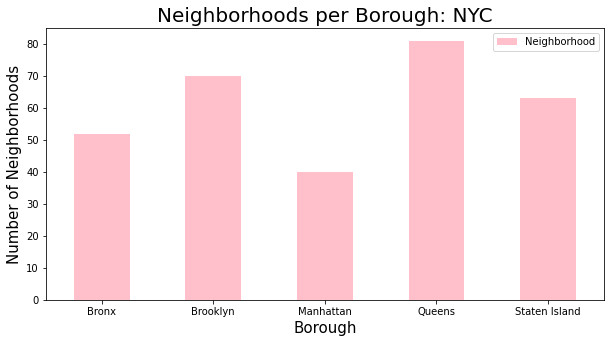

In [9]:
clr = "pink"
df_nyc.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Number of Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

As we can see Queens is the Borough that have the more of Neighborhoods, follow by Brooklyn then Staten Island

### In this first step we are going to use the foursquare api, to get the rating of Caribbean restaurants in New York City. We assume that we can not use it specificly for Haitian restaurant or creole restaurant. 

In [47]:
# queens has most neighborhoods
# prepare neighborhood list that contains Caribbean restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Caribbean_restaurant_nyc = pd.DataFrame(columns=column_names)
count=1
for row in df_nyc.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Caribbean_restaurant = venues[venues['Category']=='Caribbean Restaurant']   
    print('(',count,'/',len(df_nyc),')','Caribbean Restaurants in '+Neighborhood+', '+Borough+':'+str(len(Caribbean_restaurant)))
    print(row)
    for resturant_detail in Caribbean_restaurant.values.tolist():
        id, name , category=resturant_detail
        Caribbean_restaurant_nyc = Caribbean_restaurant_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Caribbean Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Caribbean Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Caribbean Restaurants in Eastchester, Bronx:3
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Caribbean Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Caribbean Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Caribbean Restaurants in Kingsbridge, Bronx:1
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Caribbean Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Caribbean Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Caribbean Restaurants in N

( 67 / 306 ) Caribbean Restaurants in Carroll Gardens, Brooklyn:0
['Brooklyn', 'Carroll Gardens', 40.680540231076485, -73.99465372828006]
( 68 / 306 ) Caribbean Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Caribbean Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Caribbean Restaurants in Fort Greene, Brooklyn:1
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Caribbean Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Caribbean Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Caribbean Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Caribbean Restaurants in Starrett City, Brooklyn:1
['Brooklyn', 'Starrett City', 

( 129 / 306 ) Caribbean Restaurants in Financial District, Manhattan:0
['Manhattan', 'Financial District', 40.70710710727048, -74.0106654452127]
( 130 / 306 ) Caribbean Restaurants in Astoria, Queens:0
['Queens', 'Astoria', 40.76850859335492, -73.91565374304234]
( 131 / 306 ) Caribbean Restaurants in Woodside, Queens:0
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Caribbean Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Caribbean Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Caribbean Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Caribbean Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Caribbean Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.8444750

( 194 / 306 ) Caribbean Restaurants in Brookville, Queens:0
['Queens', 'Brookville', 40.66000322733613, -73.75175310731153]
( 195 / 306 ) Caribbean Restaurants in Bellaire, Queens:0
['Queens', 'Bellaire', 40.73301404027834, -73.73889198912481]
( 196 / 306 ) Caribbean Restaurants in North Corona, Queens:1
['Queens', 'North Corona', 40.7540709990489, -73.85751790676447]
( 197 / 306 ) Caribbean Restaurants in Forest Hills Gardens, Queens:0
['Queens', 'Forest Hills Gardens', 40.7146110815117, -73.8410221123401]
( 198 / 306 ) Caribbean Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Caribbean Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Caribbean Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Caribbean Restaurants in Rosebank, Staten Island:0
['State

( 254 / 306 ) Caribbean Restaurants in Clifton, Staten Island:0
['Staten Island', 'Clifton', 40.61917845202843, -74.072642445484]
( 255 / 306 ) Caribbean Restaurants in Concord, Staten Island:0
['Staten Island', 'Concord', 40.6044731896879, -74.08402364740358]
( 256 / 306 ) Caribbean Restaurants in Emerson Hill, Staten Island:0
['Staten Island', 'Emerson Hill', 40.606794394801, -74.09776206972522]
( 257 / 306 ) Caribbean Restaurants in Randall Manor, Staten Island:0
['Staten Island', 'Randall Manor', 40.63563000681151, -74.09805062373887]
( 258 / 306 ) Caribbean Restaurants in Howland Hook, Staten Island:0
['Staten Island', 'Howland Hook', 40.63843283794795, -74.18622331749823]
( 259 / 306 ) Caribbean Restaurants in Elm Park, Staten Island:0
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) Caribbean Restaurants in Remsen Village, Brooklyn:2
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Caribbean Restaurants in New

In [48]:
#Caribbean_restaurant_nyc.to_csv('caribbean_restaurant_nyc.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
Caribbean_restaurant_nyc.to_csv('caribbean_restaurant_nyc.csv') 

In [49]:
Caribbean_nyc = pd.read_csv('caribbean_restaurant_nyc.csv')
Caribbean_restaurant_nyc.tail()

,Borough,Neighborhood,ID,Name
52,Bronx,Claremont Village,4bb794d41261d13a2583e798,Golden Krust Caribbean Restaurant
53,Brooklyn,Broadway Junction,4e42a587aeb79367c7e9f663,Golden Krust Caribbean Restaurant
54,Brooklyn,Erasmus,4b53503bf964a520d29627e3,Exquisite Delight
55,Brooklyn,Erasmus,4d95f915e07ea35d0f03b402,Trini Breakfast Shed II
56,Brooklyn,Erasmus,4b66446af964a520621b2be3,Golden Krust Caribbean Restaurant


In [76]:
Caribbean_restaurant_nyc

,Borough,Neighborhood,ID,Name
0,Bronx,Eastchester,515cc20ce4b0deb133b8e89b,Fish & Ting
1,Bronx,Eastchester,4c632fbaeb82d13a3c5007d6,Golden Krust Caribbean Restaurant
2,Bronx,Eastchester,4dbf84a24df0f8fd6b88c9b6,Royal Caribbean Bakery
3,Bronx,Kingsbridge,4bd8e98811dcc928f865f833,El Malecon
4,Bronx,Williamsbridge,4ca7451314c337042fadc73b,The Dumplin Shop
5,Bronx,Fordham,4bab5b5bf964a520fba23ae3,Golden Krust Caribbean Restaurant
6,Bronx,Olinville,4c07e7f97e3fc9280676ef82,Feroza's Roti Shop
7,Bronx,Olinville,4f627f50e4b04d4b13d32f90,Richie Rich
8,Bronx,Concourse,4c6daa9e06ed6dcbbe91a422,Concourse Jamaican Bakery
9,Brooklyn,Flatbush,4bbd184f8ec3d13af9ae1b28,Fisherman's Cove


In [50]:
Caribbean_restaurant_nyc.shape

(57, 4)

### We found 57 Caribbean Restaurants in NYC

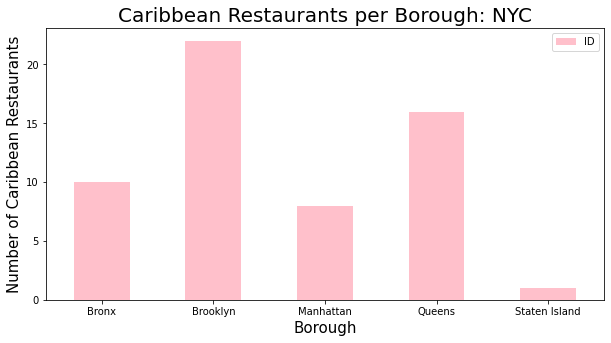

In [51]:
Caribbean_restaurant_nyc.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Caribbean Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Number of Caribbean Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

As we can see Brooklyn is the Borough that have the most of Carribean Restaurant in New york city. It's totally normal because boast a dense concentration of caribbean culture year-round.

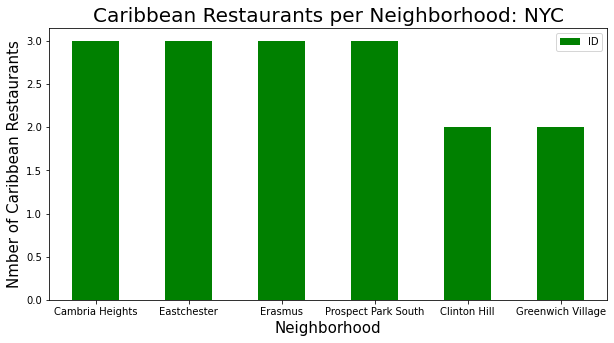

In [52]:
NOofNeigh = 6 # top number for graphing all the same past 6
Caribbean_restaurant_nyc.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color="green")
plt.title('Caribbean Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Nmber of Caribbean Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [55]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Caribbean_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in Caribbean_restaurant_nyc.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Caribbean_restaurant_nyc),')','processed')
    Caribbean_rest_stats_ny = Caribbean_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5f0e738413c4633ef5b518e0'}, 'response': {'venue': {'id': '515cc20ce4b0deb133b8e89b', 'name': 'Fish & Ting', 'contact': {}, 'location': {'address': '4063 Boston Rd', 'lat': 40.885656, 'lng': -73.829197, 'labeledLatLngs': [{'label': 'display', 'lat': 40.885656, 'lng': -73.829197}, {'label': 'entrance', 'lat': 40.885608, 'lng': -73.829175}], 'postalCode': '10466', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4063 Boston Rd', 'Bronx, NY 10466', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fish--ting/515cc20ce4b0deb133b8e89b', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, '

{'meta': {'code': 200, 'requestId': '5f0e73a5db51f14150f875cc'}, 'response': {'venue': {'id': '4c632fbaeb82d13a3c5007d6', 'name': 'Golden Krust Caribbean Restaurant', 'contact': {'phone': '7183250060', 'formattedPhone': '(718) 325-0060', 'twitter': 'goldenkrustbkry'}, 'location': {'address': '3818 Dyre Avenue', 'crossStreet': 'East 233 Street', 'lat': 40.888488, 'lng': -73.83108299999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.888488, 'lng': -73.83108299999999}, {'label': 'entrance', 'lat': 40.888488, 'lng': -73.831147}], 'postalCode': '10466', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3818 Dyre Avenue (East 233 Street)', 'Bronx, NY 10466', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-krust-caribbean-restaurant/4c632fbaeb82d13a3c5007d6', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 

{'meta': {'code': 200, 'requestId': '5f0e738aba4b825abd1d8987'}, 'response': {'venue': {'id': '4dbf84a24df0f8fd6b88c9b6', 'name': 'Royal Caribbean Bakery', 'contact': {'phone': '3095294865', 'formattedPhone': '(309) 529-4865'}, 'location': {'address': '3815 Dyre Ave', 'lat': 40.888249, 'lng': -73.831661, 'labeledLatLngs': [{'label': 'display', 'lat': 40.888249, 'lng': -73.831661}, {'label': 'entrance', 'lat': 40.888273, 'lng': -73.831466}], 'postalCode': '10466', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3815 Dyre Ave', 'Bronx, NY 10466', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/royal-caribbean-bakery/4dbf84a24df0f8fd6b88c9b6', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'

{'meta': {'code': 200, 'requestId': '5f0e73ed084cc352604e70ad'}, 'response': {'venue': {'id': '4bd8e98811dcc928f865f833', 'name': 'El Malecon', 'contact': {'phone': '7104325155', 'formattedPhone': '(710) 432-5155', 'twitter': 'maleconnyc'}, 'location': {'address': '5592 Broadway', 'crossStreet': 'at W 231st St', 'lat': 40.87933806746814, 'lng': -73.90445707056641, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87933806746814, 'lng': -73.90445707056641}, {'label': 'entrance', 'lat': 40.879281, 'lng': -73.904333}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5592 Broadway (at W 231st St)', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/el-malecon/4bd8e98811dcc928f865f833', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '5f0e73b4a214fa7af2169824'}, 'response': {'venue': {'id': '4ca7451314c337042fadc73b', 'name': 'The Dumplin Shop', 'contact': {'phone': '7186533143', 'formattedPhone': '(718) 653-3143'}, 'location': {'address': '1530 E 222nd St', 'lat': 40.88414315581045, 'lng': -73.856449229114, 'labeledLatLngs': [{'label': 'display', 'lat': 40.88414315581045, 'lng': -73.856449229114}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1530 E 222nd St', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-dumplin-shop/4ca7451314c337042fadc73b', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'url': 'http://www.thedum

{'meta': {'code': 200, 'requestId': '5f0e73e01898e563dfb2afc9'}, 'response': {'venue': {'id': '4bab5b5bf964a520fba23ae3', 'name': 'Golden Krust Caribbean Restaurant', 'contact': {'phone': '7182953672', 'formattedPhone': '(718) 295-3672', 'twitter': 'goldenkrustbkry'}, 'location': {'address': '2521 Webster Ave.', 'crossStreet': 'Fordham', 'lat': 40.8615608215332, 'lng': -73.89178466796875, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8615608215332, 'lng': -73.89178466796875}], 'postalCode': '10458', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2521 Webster Ave. (Fordham)', 'Bronx, NY 10458', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-krust-caribbean-restaurant/4bab5b5bf964a520fba23ae3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 's

{'meta': {'code': 200, 'requestId': '5f0e736d7dadce74d11ff5de'}, 'response': {'venue': {'id': '4f627f50e4b04d4b13d32f90', 'name': 'Richie Rich', 'contact': {'phone': '7186555923', 'formattedPhone': '(718) 655-5923'}, 'location': {'address': '804 Burke Ave', 'lat': 40.87149581108973, 'lng': -73.86442424824064, 'labeledLatLngs': [{'label': 'display', 'lat': 40.87149581108973, 'lng': -73.86442424824064}], 'postalCode': '10467', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['804 Burke Ave', 'Bronx, NY 10467', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/richie-rich/4f627f50e4b04d4b13d32f90', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d146941735', 'name': 'Deli / Bodega', 'pluralName': 'Delis 

{'meta': {'code': 200, 'requestId': '5f0e739a460fb939349553b0'}, 'response': {'venue': {'id': '4bbd184f8ec3d13af9ae1b28', 'name': "Fisherman's Cove", 'contact': {'phone': '7188591580', 'formattedPhone': '(718) 859-1580'}, 'location': {'address': '4 Newkirk Plz', 'lat': 40.63546710297942, 'lng': -73.96286913080004, 'labeledLatLngs': [{'label': 'display', 'lat': 40.63546710297942, 'lng': -73.96286913080004}, {'label': 'entrance', 'lat': 40.635512, 'lng': -73.962744}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4 Newkirk Plz', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fishermans-cove/4bbd184f8ec3d13af9ae1b28', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '5f0e74015cb8b40ce0645eaa'}, 'response': {'venue': {'id': '57a22aad498e0078cc75ac8d', 'name': 'Jemz', 'contact': {'phone': '3474420009', 'formattedPhone': '(347) 442-0009', 'twitter': 'jemz_ny'}, 'location': {'address': '1171 Saints Johns Pl', 'lat': 40.67124811669991, 'lng': -73.93947958946228, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67124811669991, 'lng': -73.93947958946228}], 'postalCode': '11213', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1171 Saints Johns Pl', 'Brooklyn, NY 11213', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jemz/57a22aad498e0078cc75ac8d', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 0}, 'url': '

{'meta': {'code': 200, 'requestId': '5f0e7390722cee4eda5ac069'}, 'response': {'venue': {'id': '5a4d750e3fcee83d3f3ce36c', 'name': 'The Islands', 'contact': {'phone': '7183983575', 'formattedPhone': '(718) 398-3575'}, 'location': {'address': '671 Washington Ave', 'lat': 40.67703587674722, 'lng': -73.96356321538423, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67703587674722, 'lng': -73.96356321538423}], 'postalCode': '11238', 'cc': 'US', 'neighborhood': 'Prospect Heights', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['671 Washington Ave', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/the-islands/5a4d750e3fcee83d3f3ce36c', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': 

{'meta': {'code': 200, 'requestId': '5f0e734b26cd0340b02a3496'}, 'response': {'venue': {'id': '5ae70ca64c954c002c618bff', 'name': 'Imani Caribbean Kitchen & Bar', 'contact': {}, 'location': {'address': '271 Adelphi St', 'crossStreet': 'DeKalb Ave', 'lat': 40.68949374298435, 'lng': -73.97095919400672, 'labeledLatLngs': [{'label': 'display', 'lat': 40.68949374298435, 'lng': -73.97095919400672}], 'postalCode': '11205', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['271 Adelphi St (DeKalb Ave)', 'New York, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/imani-caribbean-kitchen--bar/5ae70ca64c954c002c618bff', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pl

{'meta': {'code': 200, 'requestId': '5f0e7388d6c5c73388f2a699'}, 'response': {'venue': {'id': '4c50b469375c0f47c406bb92', 'name': 'Golden Krust Caribbean Restaurant', 'contact': {'phone': '7182771003', 'formattedPhone': '(718) 277-1003', 'twitter': 'goldenkrustbkry'}, 'location': {'address': '1364 Pennsylvania Ave.', 'lat': 40.647002902822784, 'lng': -73.88348879657343, 'labeledLatLngs': [{'label': 'display', 'lat': 40.647002902822784, 'lng': -73.88348879657343}], 'postalCode': '11239', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1364 Pennsylvania Ave.', 'Brooklyn, NY 11239', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-krust-caribbean-restaurant/4c50b469375c0f47c406bb92', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '5f0e73a6bcc2f35f094e277a'}, 'response': {'venue': {'id': '4e7007407d8b21fe9d1a809c', 'name': 'Dee and Ricky Homecooking', 'contact': {}, 'location': {'address': '503 Myrtle Ave', 'lat': 40.69360879703554, 'lng': -73.96471271702187, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69360879703554, 'lng': -73.96471271702187}, {'label': 'entrance', 'lat': 40.69368, 'lng': -73.964766}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['503 Myrtle Ave', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dee-and-ricky-homecooking/4e7007407d8b21fe9d1a809c', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1

{'meta': {'code': 200, 'requestId': '5f0e7393ba4b825abd1d9bff'}, 'response': {'venue': {'id': '536fd50d498ec249d9620b42', 'name': "Wray's", 'contact': {'phone': '7187891111', 'formattedPhone': '(718) 789-1111', 'facebook': '311273362221720', 'facebookName': "Wray's Caribbean and Seafood Cuisine"}, 'location': {'address': '503 Myrtle Ave', 'crossStreet': 'btwn Ryerson St & Grand Ave', 'lat': 40.69359969637009, 'lng': -73.96472877211437, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69359969637009, 'lng': -73.96472877211437}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['503 Myrtle Ave (btwn Ryerson St & Grand Ave)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wrays/536fd50d498ec249d9620b42', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sq

{'meta': {'code': 200, 'requestId': '5f0e7393722cee4eda5ac840'}, 'response': {'venue': {'id': '4bd3475c046076b084a97571', 'name': "Culpepper's", 'contact': {'phone': '7189404122', 'formattedPhone': '(718) 940-4122'}, 'location': {'address': '1082 Nostrand Ave', 'lat': 40.660418732401496, 'lng': -73.95255326575268, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660418732401496, 'lng': -73.95255326575268}, {'label': 'entrance', 'lat': 40.661423, 'lng': -73.950882}], 'postalCode': '11225', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1082 Nostrand Ave', 'Brooklyn, NY 11225', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/culpeppers/4bd3475c046076b084a97571', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '5f0e7514535a1a4eedf76b22'}, 'response': {'venue': {'id': '57597fd8498e2922f0ff1b22', 'name': 'Island Express', 'contact': {'phone': '7184699049', 'formattedPhone': '(718) 469-9049', 'twitter': 'islandexpressny'}, 'location': {'address': '998 Flatbush Ave', 'lat': 40.64711056993405, 'lng': -73.95810792209716, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64711056993405, 'lng': -73.95810792209716}, {'label': 'entrance', 'lat': 40.64702, 'lng': -73.958266}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['998 Flatbush Ave', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/island-express/57597fd8498e2922f0ff1b22', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '

{'meta': {'code': 200, 'requestId': '5f0e7339d34c0476ccf01ab6'}, 'response': {'venue': {'id': '4cb8984bbac937044c4fde7c', 'name': 'Golden Krust Caribbean Restaurant', 'contact': {'phone': '7184624044', 'formattedPhone': '(718) 462-4044', 'twitter': 'goldenkrustbkry'}, 'location': {'address': '1617 Church Avenue', 'lat': 40.64898270741795, 'lng': -73.96434545466518, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64898270741795, 'lng': -73.96434545466518}, {'label': 'entrance', 'lat': 40.649051, 'lng': -73.964363}], 'postalCode': '11225', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1617 Church Avenue', 'Brooklyn, NY 11225', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-krust-caribbean-restaurant/4cb8984bbac937044c4fde7c', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/

{'meta': {'code': 200, 'requestId': '5f0e7427aaa9a66827d5ff2d'}, 'response': {'venue': {'id': '4fc17d82e4b0c9a9f167ba1f', 'name': 'El Gran Canario', 'contact': {'phone': '7183885555', 'formattedPhone': '(718) 388-5555'}, 'location': {'address': '174 Borinquen Pl', 'crossStreet': 'Keap St', 'lat': 40.71063690699807, 'lng': -73.95379270440853, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71063690699807, 'lng': -73.95379270440853}, {'label': 'entrance', 'lat': 40.710541, 'lng': -73.953895}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['174 Borinquen Pl (Keap St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/el-gran-canario/4fc17d82e4b0c9a9f167ba1f', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 's

{'meta': {'code': 200, 'requestId': '5f0e729d03b4bc5745e4f510'}, 'response': {'venue': {'id': '4b818d64f964a52079ae30e3', 'name': 'Cafe El Puente', 'contact': {'phone': '7183882416', 'formattedPhone': '(718) 388-2416'}, 'location': {'address': '231 S 4th St', 'crossStreet': 'Havemeyer St', 'lat': 40.71044798477822, 'lng': -73.95892054500743, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71044798477822, 'lng': -73.95892054500743}, {'label': 'entrance', 'lat': 40.710519, 'lng': -73.958898}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['231 S 4th St (Havemeyer St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-el-puente/4b818d64f964a52079ae30e3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 's

{'meta': {'code': 200, 'requestId': '5f0e719fca618c567b77e6fa'}, 'response': {'venue': {'id': '4afcba6af964a5206d2522e3', 'name': 'La Casa del Mofongo', 'contact': {'phone': '2127401200', 'formattedPhone': '(212) 740-1200', 'twitter': 'lacasamofongo'}, 'location': {'address': '1447 Saint Nicholas Ave', 'crossStreet': 'btwn 182nd St & 183rd St', 'lat': 40.85026656753515, 'lng': -73.93314532362541, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85026656753515, 'lng': -73.93314532362541}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1447 Saint Nicholas Ave (btwn 182nd St & 183rd St)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/la-casa-del-mofongo/4afcba6af964a5206d2522e3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories

{'meta': {'code': 200, 'requestId': '5f0e720e6655f737d6a9b190'}, 'response': {'venue': {'id': '4be65857bcef2d7f512005e5', 'name': 'Caridad Restaurant', 'contact': {'phone': '2125449286', 'formattedPhone': '(212) 544-9286'}, 'location': {'address': '4799 Broadway', 'lat': 40.866463, 'lng': -73.925432, 'labeledLatLngs': [{'label': 'display', 'lat': 40.866463, 'lng': -73.925432}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4799 Broadway', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caridad-restaurant/4be65857bcef2d7f512005e5', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Moderate', 'cu

{'meta': {'code': 200, 'requestId': '5f0e731643266858bd51bc98'}, 'response': {'venue': {'id': '4a7a35faf964a520dee81fe3', 'name': 'One Stop Patty Shop', 'contact': {'phone': '2124917485', 'formattedPhone': '(212) 491-7485'}, 'location': {'address': '1708 Amsterdam Ave', 'crossStreet': 'btw 144th & 145th', 'lat': 40.825013866091766, 'lng': -73.94772136347088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.825013866091766, 'lng': -73.94772136347088}, {'label': 'entrance', 'lat': 40.824982, 'lng': -73.947998}], 'postalCode': '10031', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1708 Amsterdam Ave (btw 144th & 145th)', 'New York, NY 10031', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/one-stop-patty-shop/4a7a35faf964a520dee81fe3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/

{'meta': {'code': 200, 'requestId': '5f0e742aaaa9a66827d604d4'}, 'response': {'venue': {'id': '5645609b498e47952f22cd7d', 'name': 'Jerkyz', 'contact': {}, 'location': {'address': '2394 Adam Clayton Powell Jr Blvd', 'crossStreet': '139th Street', 'lat': 40.81817689825104, 'lng': -73.94148093717857, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81817689825104, 'lng': -73.94148093717857}, {'label': 'entrance', 'lat': 40.818433, 'lng': -73.94173}], 'postalCode': '10030', 'cc': 'US', 'neighborhood': 'Central Harlem', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2394 Adam Clayton Powell Jr Blvd (139th Street)', 'New York, NY 10030', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jerkyz/5645609b498e47952f22cd7d', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 's

{'meta': {'code': 200, 'requestId': '5f0e73230f668a375cde8903'}, 'response': {'venue': {'id': '40fc6080f964a520150b1fe3', 'name': 'Negril Village', 'contact': {'phone': '2124772804', 'formattedPhone': '(212) 477-2804', 'twitter': 'negrilvillage'}, 'location': {'address': '70 W 3rd St', 'crossStreet': 'at Bleecker St.', 'lat': 40.72956569490788, 'lng': -73.99830435081743, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72956569490788, 'lng': -73.99830435081743}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['70 W 3rd St (at Bleecker St.)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/negril-village/40fc6080f964a520150b1fe3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': 

{'meta': {'code': 200, 'requestId': '5f0e7385ccded3791ab116a0'}, 'response': {'venue': {'id': '537822d3498edcf629cebd3d', 'name': "Miss Lily's 7A", 'contact': {'phone': '2128121482', 'formattedPhone': '(212) 812-1482', 'twitter': 'misslilyschat'}, 'location': {'address': '109 Avenue A', 'crossStreet': 'at E 7th St', 'lat': 40.72605803974587, 'lng': -73.98368581540872, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72605803974587, 'lng': -73.98368581540872}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['109 Avenue A (at E 7th St)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/miss-lilys-7a/537822d3498edcf629cebd3d', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}],

{'meta': {'code': 200, 'requestId': '5f0e73e2ce241a5e0303177c'}, 'response': {'venue': {'id': '4b9d2a05f964a520769536e3', 'name': 'Kaieteur Restaurant', 'contact': {'phone': '7188500787', 'formattedPhone': '(718) 850-0787'}, 'location': {'address': '8712 Lefferts Blvd', 'lat': 40.69956989231225, 'lng': -73.83079342640727, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69956989231225, 'lng': -73.83079342640727}], 'postalCode': '11418', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8712 Lefferts Blvd', 'Jamaica, NY 11418', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kaieteur-restaurant/4b9d2a05f964a520769536e3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d10f941735', 'name': 'Indian 

{'meta': {'code': 200, 'requestId': '5f0e742caaa9a66827d60a02'}, 'response': {'venue': {'id': '4b8abd9cf964a520b07d32e3', 'name': 'Mangu Grill', 'contact': {'phone': '7183219982', 'formattedPhone': '(718) 321-9982'}, 'location': {'address': '15-03 College Point Blvd', 'lat': 40.784095, 'lng': -73.845659, 'labeledLatLngs': [{'label': 'display', 'lat': 40.784095, 'lng': -73.845659}], 'postalCode': '11356', 'cc': 'US', 'city': 'College Point', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15-03 College Point Blvd', 'College Point, NY 11356', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mangu-grill/4b8abd9cf964a520b07d32e3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'url': 'http://mangugrill.com

{'meta': {'code': 200, 'requestId': '5f0e743c441b12212f2a261c'}, 'response': {'venue': {'id': '4c82afb974d7b60cf60983d8', 'name': 'Golden Krust Caribbean Restaurant', 'contact': {'phone': '7186580266', 'formattedPhone': '(718) 658-0266', 'twitter': 'goldenkrustbkry'}, 'location': {'address': '92-21 Parsons Blvd', 'lat': 40.70281213239041, 'lng': -73.80002101567946, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70281213239041, 'lng': -73.80002101567946}], 'postalCode': '11432', 'cc': 'US', 'city': 'Queens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['92-21 Parsons Blvd', 'Queens, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-krust-caribbean-restaurant/4c82afb974d7b60cf60983d8', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '5f0e73a8460fb9393495724d'}, 'response': {'venue': {'id': '5130c73e72da35b105337efe', 'name': "Anita's Roti Shop", 'contact': {'phone': '7186583439', 'formattedPhone': '(718) 658-3439', 'twitter': 'anitasrotishop', 'facebook': '407104092710838', 'facebookUsername': 'AnitasRotiShop', 'facebookName': "Anita's Roti Shop"}, 'location': {'address': '106-13 Guy R Brewer Blvd', 'crossStreet': 'Guy R Brewer Blvd and South Road', 'lat': 40.69947052001953, 'lng': -73.79302215576172, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69947052001953, 'lng': -73.79302215576172}], 'postalCode': '11433', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['106-13 Guy R Brewer Blvd (Guy R Brewer Blvd and South Road)', 'Jamaica, NY 11433', 'United States']}, 'canonicalUrl': 'https://foursquare.com/anitasrotishop', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restau

{'meta': {'code': 200, 'requestId': '5f0e73c7b0500c61ec0ba82f'}, 'response': {'venue': {'id': '4d1e1fec8629224b2f85ff86', 'name': 'Fah Mas', 'contact': {'phone': '7185259646', 'formattedPhone': '(718) 525-9646'}, 'location': {'address': '115-07 Farmers Blvd', 'lat': 40.69579052646841, 'lng': -73.76164174702575, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69579052646841, 'lng': -73.76164174702575}], 'postalCode': '11412', 'cc': 'US', 'city': 'Saint Albans', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['115-07 Farmers Blvd', 'Saint Albans, NY 11412', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/fah-mas/4d1e1fec8629224b2f85ff86', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier':

{'meta': {'code': 200, 'requestId': '5f0e71a6ca618c567b77f762'}, 'response': {'venue': {'id': '55b3f118498ed94dd9512c6f', 'name': 'Epi Dor Kreyol Restaurant And Bakery', 'contact': {'phone': '7187230001', 'formattedPhone': '(718) 723-0001'}, 'location': {'address': '223-18 Linden Blvd', 'crossStreet': 'Linden And 24th Street', 'lat': 40.69393616230529, 'lng': -73.73704321622488, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69393616230529, 'lng': -73.73704321622488}], 'postalCode': '11411', 'cc': 'US', 'city': 'Cambria Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['223-18 Linden Blvd (Linden And 24th Street)', 'Cambria Heights, NY 11411', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/epi-dor-kreyol-restaurant-and-bakery/55b3f118498ed94dd9512c6f', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cate

{'meta': {'code': 200, 'requestId': '5f0e73f6ac9cfa75fe54ccd2'}, 'response': {'venue': {'id': '52d0cb3511d271f8bcf46c1f', 'name': 'Pa-Nash Eurosoul', 'contact': {'phone': '7189786094', 'formattedPhone': '(718) 978-6094', 'twitter': 'panashnyc'}, 'location': {'address': '144-14 243rd St', 'lat': 40.66005079125288, 'lng': -73.73978149653364, 'labeledLatLngs': [{'label': 'display', 'lat': 40.66005079125288, 'lng': -73.73978149653364}], 'postalCode': '11422', 'cc': 'US', 'city': 'Rosedale', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['144-14 243rd St', 'Rosedale, NY 11422', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panash-eurosoul/52d0cb3511d271f8bcf46c1f', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c3941735', 'na

{'meta': {'code': 200, 'requestId': '5f0e73b3bcc2f35f094e43df'}, 'response': {'venue': {'id': '4ded1ea66365d208a47006cd', 'name': 'Golden Krust Caribbean Restaurant', 'contact': {'phone': '7183271261', 'formattedPhone': '(718) 327-1261', 'twitter': 'goldenkrust'}, 'location': {'address': '1930 Mott Avenue', 'lat': 40.604083, 'lng': -73.752224, 'labeledLatLngs': [{'label': 'display', 'lat': 40.604083, 'lng': -73.752224}, {'label': 'entrance', 'lat': 40.604094, 'lng': -73.752427}], 'postalCode': '11412', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1930 Mott Avenue', 'Far Rockaway, NY 11412', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-krust-caribbean-restaurant/4ded1ea66365d208a47006cd', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 

{'meta': {'code': 200, 'requestId': '5f0e71a9ca618c567b77fce2'}, 'response': {'venue': {'id': '4b5b34e8f964a5202ceb28e3', 'name': 'Golden Krust', 'contact': {'phone': '7183412011', 'formattedPhone': '(718) 341-2011'}, 'location': {'address': '138-58 Brookville Blvd', 'lat': 40.667382234743044, 'lng': -73.73739489124435, 'labeledLatLngs': [{'label': 'display', 'lat': 40.667382234743044, 'lng': -73.73739489124435}], 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['138-58 Brookville Blvd', 'Jamaica, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-krust/4b5b34e8f964a5202ceb28e3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verified': True, 'stats': {'tipCount': 4}, 'url': 'http://goldenkrustbakery.com', 

{'meta': {'code': 200, 'requestId': '5f0e72186655f737d6a9c830'}, 'response': {'venue': {'id': '4bafbddbf964a520df1c3ce3', 'name': 'Golden Krust Caribbean Bakery and Grill', 'contact': {'phone': '3472860178', 'formattedPhone': '(347) 286-0178'}, 'location': {'address': '31 Victory Blvd', 'crossStreet': 'btwn Bay St & St. Marks Pl', 'lat': 40.637980999999996, 'lng': -74.076454, 'labeledLatLngs': [{'label': 'display', 'lat': 40.637980999999996, 'lng': -74.076454}, {'label': 'entrance', 'lat': 40.63789, 'lng': -74.076402}], 'postalCode': '10301', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['31 Victory Blvd (btwn Bay St & St. Marks Pl)', 'Staten Island, NY 10301', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-krust-caribbean-bakery-and-grill/4bafbddbf964a520df1c3ce3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 

{'meta': {'code': 200, 'requestId': '5f0e7407b7c12b634ddffcc9'}, 'response': {'venue': {'id': '4e9ecdd9722edab8d2cdf221', 'name': "Brucee's Patties", 'contact': {'phone': '7189222253', 'formattedPhone': '(718) 922-2253'}, 'location': {'address': '9509 Church Ave', 'crossStreet': 'Between East 95th and East 96th Street', 'lat': 40.65530171889906, 'lng': -73.91618043929961, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65530171889906, 'lng': -73.91618043929961}, {'label': 'entrance', 'lat': 40.655397, 'lng': -73.916153}], 'postalCode': '11212', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9509 Church Ave (Between East 95th and East 96th Street)', 'Brooklyn, NY 11212', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/brucees-patties/4e9ecdd9722edab8d2cdf221', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix':

{'meta': {'code': 200, 'requestId': '5f0e71232ada5b29561ac1c3'}, 'response': {'venue': {'id': '4e72a0e5aeb74a608a8735ec', 'name': 'Silver Krust  Restaurant', 'contact': {'phone': '7184853608', 'formattedPhone': '(718) 485-3608'}, 'location': {'address': '9001 Avenue A', 'lat': 40.651307137265626, 'lng': -73.91801407918956, 'labeledLatLngs': [{'label': 'display', 'lat': 40.651307137265626, 'lng': -73.91801407918956}, {'label': 'entrance', 'lat': 40.651366, 'lng': -73.918046}], 'postalCode': '11236', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9001 Avenue A', 'Brooklyn, NY 11236', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/silver-krust--restaurant/4e72a0e5aeb74a608a8735ec', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '5f0e73f81898e563dfb2e379'}, 'response': {'venue': {'id': '4bb794d41261d13a2583e798', 'name': 'Golden Krust Caribbean Restaurant', 'contact': {'phone': '7183781133', 'formattedPhone': '(718) 378-1133', 'twitter': 'goldenkrustbkry'}, 'location': {'address': '1299 Boston Road', 'lat': 40.831559000000006, 'lng': -73.900226, 'labeledLatLngs': [{'label': 'display', 'lat': 40.831559000000006, 'lng': -73.900226}, {'label': 'entrance', 'lat': 40.831464, 'lng': -73.900131}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1299 Boston Road', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-krust-caribbean-restaurant/4bb794d41261d13a2583e798', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/carib

{'meta': {'code': 200, 'requestId': '5f0e73ecce241a5e03032e10'}, 'response': {'venue': {'id': '4b53503bf964a520d29627e3', 'name': 'Exquisite Delight', 'contact': {'phone': '7186934643', 'formattedPhone': '(718) 693-4643'}, 'location': {'address': '2847 Church Ave', 'crossStreet': 'at Nostrand Ave', 'lat': 40.64909065673373, 'lng': -73.94924266662322, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64909065673373, 'lng': -73.94924266662322}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2847 Church Ave (at Nostrand Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/exquisite-delight/4b53503bf964a520d29627e3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '5f0e73cfb0500c61ec0bb8cc'}, 'response': {'venue': {'id': '4d95f915e07ea35d0f03b402', 'name': 'Trini Breakfast Shed II', 'contact': {'phone': '7182822646', 'formattedPhone': '(718) 282-2646', 'twitter': 'trinibreakfast'}, 'location': {'address': '3209 Church Ave', 'crossStreet': 'New York Ave', 'lat': 40.64909213035565, 'lng': -73.94923089951965, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64909213035565, 'lng': -73.94923089951965}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3209 Church Ave (New York Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/trini-breakfast-shed-ii/4d95f915e07ea35d0f03b402', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/caribbean_', 'suffix':

{'meta': {'code': 200, 'requestId': '5f0e740ab7c12b634de0030f'}, 'response': {'venue': {'id': '4b66446af964a520621b2be3', 'name': 'Golden Krust Caribbean Restaurant', 'contact': {'phone': '7184838984', 'formattedPhone': '(718) 483-8984', 'twitter': 'goldenkrustbkry'}, 'location': {'address': '2223 Church Avenue', 'crossStreet': 'at Nostrand Ave', 'lat': 40.64910636834001, 'lng': -73.94925189109235, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64910636834001, 'lng': -73.94925189109235}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2223 Church Avenue (at Nostrand Ave)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-krust-caribbean-restaurant/4b66446af964a520621b2be3', 'categories': [{'id': '4bf58dd8d48988d144941735', 'name': 'Caribbean Restaurant', 'pluralName': 'Caribbean Restaurants', 'shortName': 'Caribbean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categori

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
52,Bronx,Claremont Village,4bb794d41261d13a2583e798,Golden Krust Caribbean Restaurant,0,6.7,3
53,Brooklyn,Broadway Junction,4e42a587aeb79367c7e9f663,Golden Krust Caribbean Restaurant,4,6.5,2
54,Brooklyn,Erasmus,4b53503bf964a520d29627e3,Exquisite Delight,51,8.6,16
55,Brooklyn,Erasmus,4d95f915e07ea35d0f03b402,Trini Breakfast Shed II,20,6.8,12
56,Brooklyn,Erasmus,4b66446af964a520621b2be3,Golden Krust Caribbean Restaurant,3,6.7,4


In [57]:
Caribbean_rest_stats_ny

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Eastchester,515cc20ce4b0deb133b8e89b,Fish & Ting,24,8.6,6
1,Bronx,Eastchester,4c632fbaeb82d13a3c5007d6,Golden Krust Caribbean Restaurant,2,6.9,2
2,Bronx,Eastchester,4dbf84a24df0f8fd6b88c9b6,Royal Caribbean Bakery,2,6.3,4
3,Bronx,Kingsbridge,4bd8e98811dcc928f865f833,El Malecon,62,8.1,34
4,Bronx,Williamsbridge,4ca7451314c337042fadc73b,The Dumplin Shop,5,6.1,3
5,Bronx,Fordham,4bab5b5bf964a520fba23ae3,Golden Krust Caribbean Restaurant,3,6.8,1
6,Bronx,Olinville,4c07e7f97e3fc9280676ef82,Feroza's Roti Shop,39,8.1,24
7,Bronx,Olinville,4f627f50e4b04d4b13d32f90,Richie Rich,3,5.8,3
8,Bronx,Concourse,4c6daa9e06ed6dcbbe91a422,Concourse Jamaican Bakery,6,6.6,6
9,Brooklyn,Flatbush,4bbd184f8ec3d13af9ae1b28,Fisherman's Cove,11,6.3,5


In [58]:
Caribbean_rest_stats_ny.shape

(57, 7)

In [59]:
Caribbean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 7 columns):
Borough         57 non-null object
Neighborhood    57 non-null object
ID              57 non-null object
Name            57 non-null object
Likes           57 non-null object
Rating          57 non-null float64
Tips            57 non-null object
dtypes: float64(1), object(6)
memory usage: 3.2+ KB


In [60]:
Caribbean_rest_stats_ny['Likes'] = Caribbean_rest_stats_ny['Likes'].astype('float64')
Caribbean_rest_stats_ny['Tips'] = Caribbean_rest_stats_ny['Tips'].astype('float64')
Caribbean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 7 columns):
Borough         57 non-null object
Neighborhood    57 non-null object
ID              57 non-null object
Name            57 non-null object
Likes           57 non-null float64
Rating          57 non-null float64
Tips            57 non-null float64
dtypes: float64(3), object(4)
memory usage: 3.2+ KB


In [62]:
Caribbean_rest_stats_ny.describe()

,Likes,Rating,Tips
count,57.000000,57.000000,57.000000
mean,50.561404,6.656140,19.140351
std,153.186280,2.287936,52.919561
min,0.000000,0.000000,0.000000
25%,3.000000,6.300000,2.000000
50%,11.000000,7.000000,5.000000
75%,25.000000,8.100000,13.000000
max,970.000000,9.200000,344.000000


In [63]:
# Resturant with maximum Likes
Caribbean_rest_stats_ny.iloc[Caribbean_rest_stats_ny['Likes'].idxmax()]

Borough                                Manhattan
Neighborhood                   Greenwich Village
ID                      4d9e8aa89b91a1cdc7c958c0
Name            Miss Lily's & Melvin's Juice Box
Likes                                        970
Rating                                         9
Tips                                         344
Name: 29, dtype: object

In [64]:
# Resturant with maximum Ratings
Caribbean_rest_stats_ny.iloc[Caribbean_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood            Prospect Heights
ID              5a4d750e3fcee83d3f3ce36c
Name                         The Islands
Likes                                 57
Rating                               9.2
Tips                                  15
Name: 12, dtype: object

In [65]:
# Resturant with maximum Tips
Caribbean_rest_stats_ny.iloc[Caribbean_rest_stats_ny['Tips'].idxmax()]

Borough                                Manhattan
Neighborhood                   Greenwich Village
ID                      4d9e8aa89b91a1cdc7c958c0
Name            Miss Lily's & Melvin's Juice Box
Likes                                        970
Rating                                         9
Tips                                         344
Name: 29, dtype: object

In [66]:
ny_neighborhood_stats=Caribbean_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
9,East Village,9.2
26,Prospect Heights,9.2
17,Greenwich Village,8.9
16,Fort Greene,8.8
14,Flatlands,8.4
21,Jamaica Hills,8.2
22,Kingsbridge,8.1
18,Hamilton Heights,8.1
38,Washington Heights,8.0
8,East Flatbush,8.0


In [67]:
ny_borough_stats=Caribbean_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.325000
0,Bronx,7.000000
1,Brooklyn,6.913636
4,Staten Island,5.900000
3,Queens,5.800000


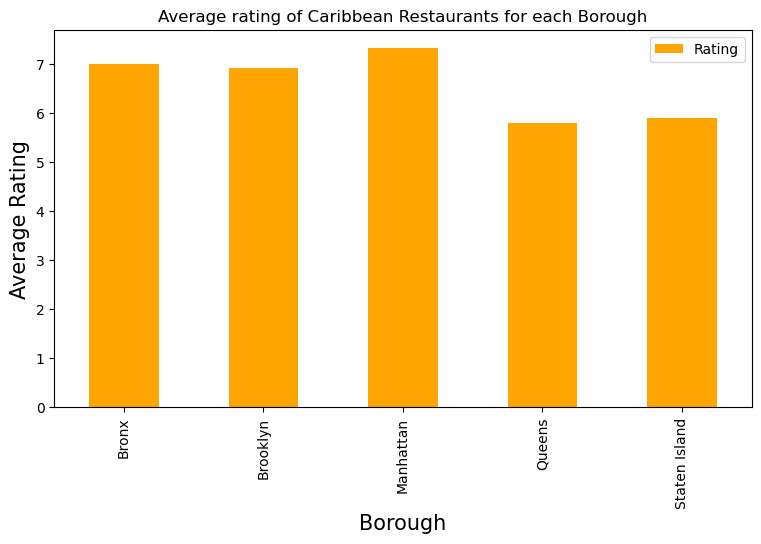

In [69]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Caribbean Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
Caribbean_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color="orange")
plt.legend()
plt.show()

In [70]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
2,Central Harlem,7.400000
5,College Point,7.200000
8,East Flatbush,8.000000
9,East Village,9.200000
10,Eastchester,7.266667
11,Erasmus,7.366667
14,Flatlands,8.400000
16,Fort Greene,8.800000
17,Greenwich Village,8.900000
18,Hamilton Heights,8.100000


In [71]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,df_nyc, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Central Harlem,40.815976,-73.943211,7.400000
1,Queens,College Point,40.784903,-73.843045,7.200000
2,Brooklyn,East Flatbush,40.641718,-73.936103,8.000000
3,Manhattan,East Village,40.727847,-73.982226,9.200000
4,Bronx,Eastchester,40.887556,-73.827806,7.266667
5,Brooklyn,Erasmus,40.646926,-73.948177,7.366667
6,Brooklyn,Flatlands,40.630446,-73.929113,8.400000
7,Brooklyn,Fort Greene,40.688527,-73.972906,8.800000
8,Manhattan,Greenwich Village,40.726933,-73.999914,8.900000
9,Manhattan,Hamilton Heights,40.823604,-73.949688,8.100000


In [74]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=10)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [75]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

In [82]:
address = 'New York City'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York city are 40.7127281, -74.0060152.


In [83]:
radius=1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius)
results = requests.get(url).json()

In [84]:
#Function to get the category

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']

    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [85]:
import json
from pandas.io.json import json_normalize

venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,The Bar Room at Temple Court,Hotel Bar,40.711448,-74.006802
1,Alba Dry Cleaner & Tailor,Laundry Service,40.711434,-74.006272
2,"The Beekman, A Thompson Hotel",Hotel,40.711173,-74.006702
3,Gibney Dance Center Downtown,Dance Studio,40.713923,-74.005661
4,City Hall Park,Park,40.712415,-74.006724


In [86]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [87]:
LIMIT = 100
nyc_venues = getNearbyVenues(names=df_nyc['Neighborhood'],
                                   latitudes=df_nyc['Latitude'],
                                   longitudes=df_nyc['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [88]:
nyc_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
2,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
5,Wakefield,40.894705,-73.847201,Shell,40.894187,-73.845862,Gas Station
6,Wakefield,40.894705,-73.847201,Subway,40.890468,-73.849152,Sandwich Place
7,Wakefield,40.894705,-73.847201,Central Deli,40.896728,-73.844387,Deli / Bodega
8,Wakefield,40.894705,-73.847201,Koss Quick Wash,40.891281,-73.849904,Laundromat
9,Co-op City,40.874294,-73.829939,Capri II Pizza,40.876374,-73.829940,Pizza Place


In [89]:
nyc_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,33,33,33,33,33,33
Annadale,12,12,12,12,12,12
Arden Heights,5,5,5,5,5,5
Arlington,6,6,6,6,6,6
Arrochar,21,21,21,21,21,21
Arverne,19,19,19,19,19,19
Astoria,100,100,100,100,100,100
Astoria Heights,14,14,14,14,14,14
Auburndale,21,21,21,21,21,21


In [90]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 430 uniques categories.


In [94]:
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood']



In [95]:
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])


In [98]:
nyc_onehot = nyc_onehot[fixed_columns]
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()


In [99]:
nyc_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North I

In [100]:
print(nyc_venues['Venue Category'].value_counts())

Pizza Place                                 445
Italian Restaurant                          322
Coffee Shop                                 315
Deli / Bodega                               285
Bakery                                      235
Bar                                         227
Chinese Restaurant                          224
Sandwich Place                              191
Grocery Store                               189
Pharmacy                                    178
Mexican Restaurant                          176
Park                                        175
Café                                        172
Donut Shop                                  166
American Restaurant                         162
Bank                                        145
Ice Cream Shop                              140
Gym / Fitness Center                        117
Sushi Restaurant                            116
Gym                                         115
Bagel Shop                              

In [101]:
# create map of New York using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_nyc['Latitude'], df_nyc['Longitude'], df_nyc['Borough'], df_nyc['Neighborhood']):
    label = '{},{}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

In [102]:
nyc_part = nyc_grouped[['Neighborhood', 'Caribbean Restaurant']]
nyc_part

,Neighborhood,Caribbean Restaurant
0,Allerton,0.000000
1,Annadale,0.000000
2,Arden Heights,0.000000
3,Arlington,0.000000
4,Arrochar,0.000000
5,Arverne,0.000000
6,Astoria,0.000000
7,Astoria Heights,0.000000
8,Auburndale,0.000000
9,Bath Beach,0.000000


In [109]:
nyc_part.shape

(301, 2)

In [103]:
nyc_merged = pd.merge(df_nyc, nyc_part, on='Neighborhood')
nyc_merged

,Borough,Neighborhood,Latitude,Longitude,Caribbean Restaurant
0,Bronx,Wakefield,40.894705,-73.847201,0.000000
1,Bronx,Co-op City,40.874294,-73.829939,0.000000
2,Bronx,Eastchester,40.887556,-73.827806,0.125000
3,Bronx,Fieldston,40.895437,-73.905643,0.000000
4,Bronx,Riverdale,40.890834,-73.912585,0.000000
5,Bronx,Kingsbridge,40.881687,-73.902818,0.013699
6,Manhattan,Marble Hill,40.876551,-73.910660,0.000000
7,Bronx,Woodlawn,40.898273,-73.867315,0.000000
8,Bronx,Norwood,40.877224,-73.879391,0.034483
9,Bronx,Williamsbridge,40.881039,-73.857446,0.200000


In [108]:
nyc_merged.shape

(305, 5)

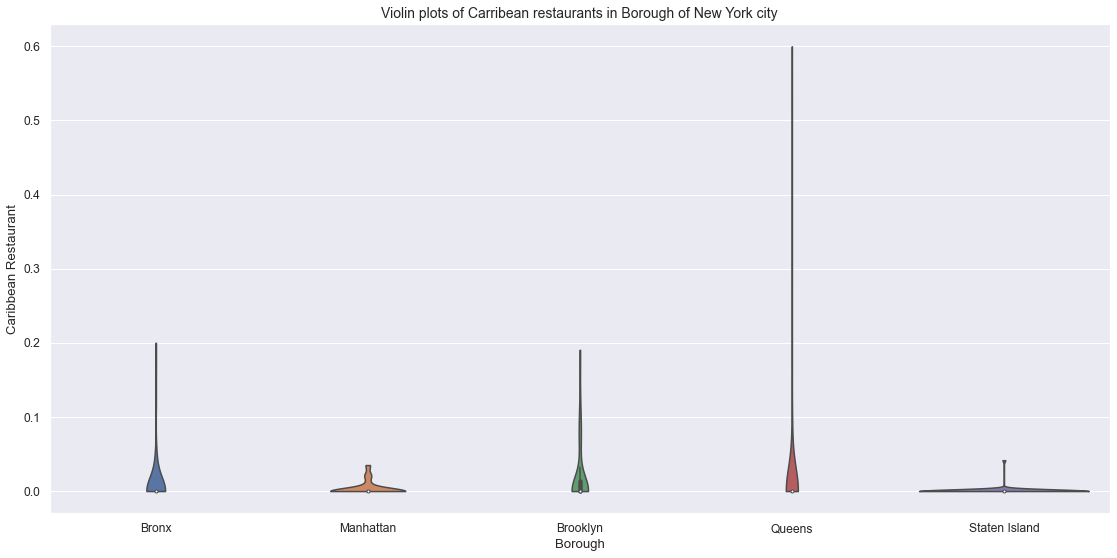

In [105]:
### 
fig = plt.figure(figsize=(19,9))

sns.set(font_scale=1.1)
sns.violinplot(y="Caribbean Restaurant", x="Borough", data=nyc_merged, cut=0);

plt.title('Violin plots of Carribean restaurants in Borough of New York city', fontsize=14)
plt.show()

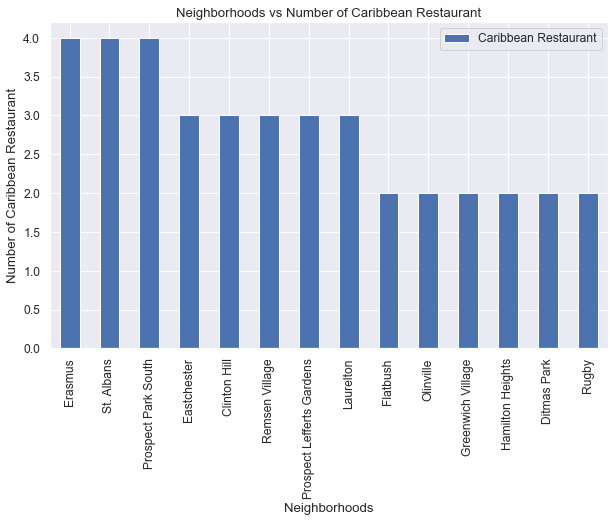

In [106]:
graph = pd.DataFrame(nyc_onehot.groupby('Neighborhood')['Caribbean Restaurant'].sum())
graph = graph.sort_values(by ='Caribbean Restaurant', ascending=False)
graph.iloc[:14].plot(kind='bar', figsize=(10,6))
plt.xlabel("Neighborhoods")
plt.ylabel("Number of Caribbean Restaurant")
plt.title("Neighborhoods vs Number of Caribbean Restaurant")
plt.show()